<a href="https://colab.research.google.com/github/citurriagab/CNN_GrapevineLeaves/blob/main/CNN_GrapevineLeaves.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Trabajo N° 2

#### Deep Learning 

**Análisis Supervisado**

**Clasificación**

*Carla Iturriaga Barrios*

*Rodrigo Lefin Carrasco*

Septiembre, 2022

#### Importe y Activación de librerías

In [117]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [118]:
import os
from os import walk
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
from torch.autograd import Variable

import torch.nn.functional as F

### 1. Datos: Imagenes de hojas de parra

**Carga del repositorio**

In [119]:
cd /content/gdrive/MyDrive/DataGrapevineLeaves

/content/gdrive/MyDrive/DataGrapevineLeaves


In [120]:
ls

TEST/  TRAIN/


In [121]:
print(os.listdir('/content/gdrive/MyDrive/DataGrapevineLeaves'))

['TEST', 'TRAIN']


In [122]:
PATH = '/content/gdrive/MyDrive/DataGrapevineLeaves'

In [123]:
data_dir = PATH + '/TRAIN'

**Transformación de la data**

In [124]:
transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()
                               ])

In [125]:
dataset = datasets.ImageFolder(data_dir, transform=transform)

In [126]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

In [127]:
data_dir

'/content/gdrive/MyDrive/DataGrapevineLeaves/TRAIN'

In [128]:
data_dir = PATH

In [129]:
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5], 
                                                            [0.5, 0.5, 0.5])])

In [130]:
train_data = datasets.ImageFolder(data_dir + '/TRAIN', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/TEST', transform=test_transforms)

In [131]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=32)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32)

**Previsualización de las imagenes de entrenamiento**

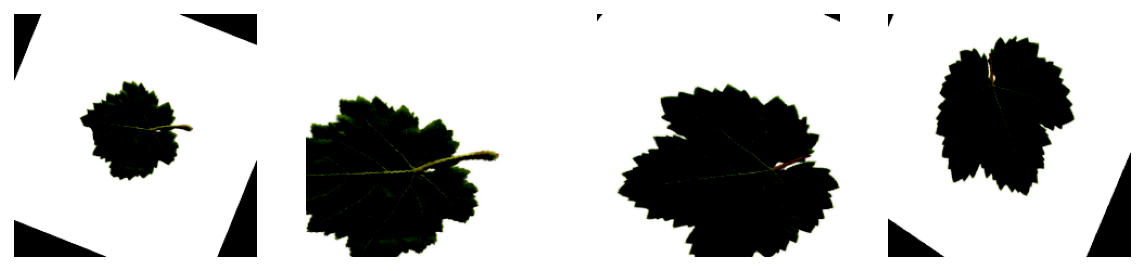

In [132]:
data_iter = iter(trainloader)

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
#     helper.imshow(images[ii], ax=ax, normalize=False)
    imshow(images[ii], ax=ax, normalize=False)

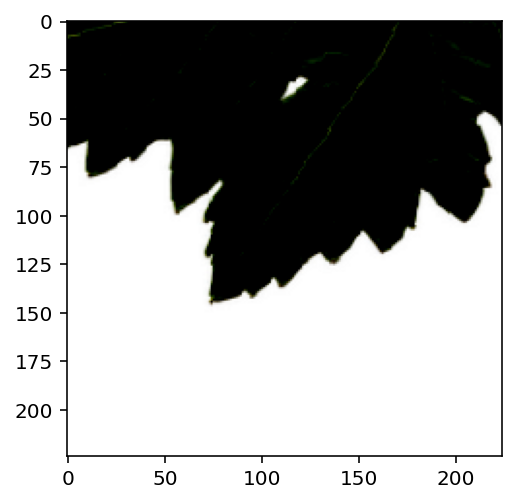

In [133]:
img_t, _ = train_data[30]
plt.imshow((img_t.permute(1, 2, 0)))
plt.show()

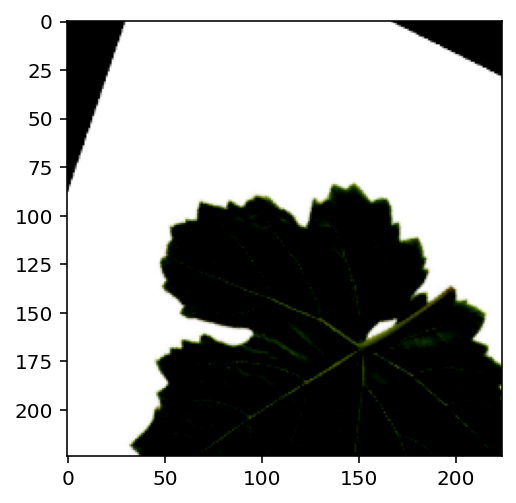

In [134]:
img_t, _ = train_data[87]
plt.imshow(img_t.permute(1, 2, 0))
plt.show()

### 2. Modelo: CNN

**Definición del Modelo**

In [150]:
# Model 
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1) # convolutional layer
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1) # convolutional layer
        self.fc1 = nn.Linear(8 * 8 * 8, 32)                     # Fully connected
        self.fc2 = nn.Linear(32, 2)                             # Fully connected
    def forward(self, x): # input img
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)        # max pooling
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)      # max pooling
        out = out.view(-1, 8 * 8 * 8)                           # tranform the out
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out  # dim: number of class

**Definición de la función de entrenamiento**

In [151]:
# Training function 
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    loss_list = []
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0 
        for imgs, labels in train_loader:  # batch 
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()               # backpro
            optimizer.step()              # update w
            
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('Epoch {}, Training loss {}'.format(epoch,
            loss_train / len(train_loader)))
            loss_list.append(loss_train / len(train_loader))
    return loss_list

**Entrenamiento del Modelo CNN**

In [152]:
# Dataloader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)

In [153]:
# Run, traning
model = CNN()                                      # call our cnn class
optimizer = torch.optim.SGD(model.parameters(), lr=0.01) # Stochastic gradient descent
loss_fn = nn.CrossEntropyLoss()                    # Loss function

Loss1 = training_loop(
    n_epochs = 50,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

ValueError: ignored

**Gráfico del Error obtenido en Entrenamiento y Búsqueda del Valor óptimo**

In [ ]:
# plot loss
plt.plot(Loss1)
plt.xlabel('Epoch(x10)')
plt.ylabel('Loss')

### 3. Métricas

In [ ]:
# Testing metric
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64,
                                            shuffle=False)
val_loader = torch.utils.data.DataLoader(test_data, batch_size=64,
                                            shuffle=False)
def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0
        with torch.no_grad():
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                # metrics: Acc, F1, AUC, Precision, Recall, 
                correct += int((predicted == labels).sum())
        print("Accuracy {}: {:.2f}".format(name , correct / total))

validate(model, train_loader, val_loader)